## Model
<figure><img src="../../../images/hill model.png\" width=400 />


## Deduction

   $ F_{SEE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_T < L_{SL}\\
   K(L - L_{SL})^2 \ \ , \ \ L_T \geq L_{SL}\\
   \end{array}
   \right.$
   
   $F_{KPE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_{CE} < L_{op}\\
   K(L - L_{op})^2 \ \ , \ \ L_{CE} \geq L_{op}\\
   \end{array}
   \right.$
     
  
   $F = \frac{F_{SEE}}{cos(\alpha)} - F_{KPE} = F_{CE} $
     
   $\dot L_{CE} = (0.25 + 0.75a)V_{max}\frac{F_{CE}-aF_L}{b} $
   
   $ b = \left\{\begin{array}{l}
   aF_L + F_{CE}/A_f\ \ , \ \ F_{CE} < F_L\\
   \frac{(2 + 2/A_f)(aF_L\overline{F}^M_{len} - F_{CE})}{\overline{F}^M_{len} - 1}   \ \ , \ \ F_{CE} \geq F_L\\
   \end{array}
   \right.$
   
   $\frac{da}{dt} = \frac{u - a}{\tau_a(u,a)}$
   
   $\tau_a(a,u) = \left\{\begin{array}{l}
   \tau_{act}(0.5 + 1.5a)\ \ , \ \ u > a\\
   \frac{\tau_{dact}}{(0.5 + 1.5a)}\ \ , \ \ u \leq a\\
   \end{array}
   \right.$
   
   $L_{SEE} = L_m - L_{CE} cos(\alpha)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib notebook

In [2]:
#Muscle properties -Parameters obtained from Table 2 of Thelen (2003).

Lce_o = 0.09 #optimal length of CE (meter)(telen 2003 dorsiflexor)
Lslack = 2.4*Lce_o #slack length of SEE, SEE strain at Fmax (meters)(telen 2003 dorsiflexor)
Fmax = 1400 #maximal isometric force (Newton)(telen 2003 dorsiflexor)
alpha = 7*np.pi/180 #penation angle degree


tau_dact = 50e-3 #young #ms
#tal_dact = 0.060 #old #ms
tau_act = 15e-3 #ms

Af = 0.25
F_m_len = 1.4 #young
#F_m_len = 1.8 #old
v_max = 10 #young
#v_max = 8 #old

dt = 1e-4

In [3]:
class muscle:
    
    def __init__(self,Lslack,Lce_o,Fmax,alpha,tau_dact,tau_act,dt,Af,F_m_len,v_max):
        
        self.Lslack = Lslack # tendon slack length
        self.Lce_o  = Lce_o # optimal muscle fiber length
        self.Fmax   = Fmax #maximal isometric DF force
        self.alpha  = alpha # DF muscle fiber pennation angle
        
        #Parameters from Nigg & Herzog (2006).
        self.UmaxTendon = 0.04 # SEE strain at Fmax
        self.width = 0.63 #max relative length change of CE
        
        self.tau_dact = tau_dact
        self.tau_act  = tau_act
        self.dt = dt
        
        self.Af = Af
        self.F_m_len = F_m_len
        self.v_max = v_max
        
        
        self.Lnorm_slack = self.Lslack/self.Lce_o #normalized slack length
        
    def TendonLength(self,Lm,Lnorm_ce):
        """
        ComputeTendonLength
        
        Inputs:
        
            Lm - Normalized muscle length
        
            Lce_o - Optimal length of the fiber
        
            Lnorm_ce - Nomalized Contract Element Lenght
        
            alpha - Angle between tendon and fiber
        
        Output:
            Lnomr_see - Normalized slack length
        
        """
    
        Lnomr_see = Lm/self.Lce_o - Lnorm_ce*np.cos(self.alpha)
    
        return Lnomr_see
    
    def TendonForce(self, L_SEE_norm):
        """
        ComputeTendonForce
    
        Inputs:
    
            L_SEE_norm - Normalized tendon length
            
            Lnorm_slack - Normalized slack length of the tendon
            
            Lce_o = Optimal length of the fiber
            
        Output:
            F_tendon_norm - Normalized tendon force
            
        """
    
        if L_SEE_norm < self.Lnorm_slack:
            F_tendon_norm = 0
        else:
            F_tendon_norm =  ((L_SEE_norm - self.Lnorm_slack)/(self.UmaxTendon*self.Lnorm_slack))**2
        
        return F_tendon_norm
    
    def ParalelElementForce(self,Lnorm_ce):
        """
        Compute Paralel Elemento Force
        
        Inputs:
        
            Lnorm_ce - Normalized Contract Element length
                                 
        Output:
            F_kpe_norm - Normalized paralel element force
    
        """
      
        if Lnorm_ce < 1:
            F_kpe_norm = 0
        else:
            F_kpe_norm = (Lnorm_ce - 1)**2
        
        return F_kpe_norm
    
    def ForceLengthCurve (self,Lnorm_ce):
        """
        Compute Force Length Curve
        
        Inputs:
        
            Lnorm_ce - Normalized Contract Element length
            
        Output:
            F0 - Normalized Force Length Element
        
        """
    
        F0 = max(0,(1-((Lnorm_ce-1)/self.width)**2))
        
        return F0
    
    def ContractileElementForce(self,F_tendon_norm,F_kpe_norm):
        """"
        Incremental Contract Element's length
    
        Inputs:
    
            F_tendon_norm - Normalized tendon force
        
            F_CE_norm - Normalized Contract Element Force
        
            alpha - Angle between tendon and fibers (rad)
        
        Output:
            F_kpe_norm - Normalized paralel element force
      
        """
        
        F_CE_norm = F_tendon_norm/np.cos(self.alpha) - F_kpe_norm
        
        return F_CE_norm
    
    def Activation(self,a,u):
        """
        Compute Activation parameter
        
        Inputs:
        
            a - Muscle activation parameter
            
            u - Muscle excitation signal
            
            dt - time step
            
        Output:
            a - Muscle activation parameter
        
        """
      
        if u > a:
            tau_a = self.tau_act*(0.5 + 1.5*a)
        else:
            tau_a = self.tau_dact/(0.5 + 1.5*a)
        
        dadt = (u-a)/tau_a # euler
    
        a = a + dadt*self.dt
    
        return a
    
    def ContractileElementDot(self,F_Lnorm, F_CE_norm,a):
        """"
        Incremental Contract Element's length
        
        Inputs:
        
            F_Lnorm - Normalized Force Length Element
            
            F_kpe_norm - Normalized paralel element force
            
        Output:
            L_CE_dot - Incremental Contract Element's length
             
        """

    
        FCE = min(a*F_Lnorm*self.F_m_len-0.001,F_CE_norm)
    
        if FCE <= a*F_Lnorm:
            b = a*F_Lnorm + FCE/self.Af
            
        else:
            b = (2 + 2/self.Af)*(a*F_Lnorm*self.F_m_len - FCE)/(self.F_m_len - 1)
            
        Lnorm_cedot  = (0.25 + 0.75*a)*v_max*((FCE - a*F_Lnorm)/b)

        return Lnorm_cedot
    

In [4]:
dorsiflexor = muscle(Lslack = Lslack, Lce_o = Lce_o, Fmax = Fmax, alpha = alpha,tau_dact = tau_dact, tau_act = tau_act, 
                     dt = dt, Af = Af, F_m_len = F_m_len, v_max = v_max)

In [5]:
dorsiflexor.Fmax

1400

## Parameters

In [6]:
## Muscle properties for human Vastus Lateralis

##parameters for the equation of motion (Nigg & Herzog, p. 562)
M = 75 #total mass in kg
proportion_mass = 0.0145
m = M*proportion_mass #kg
Lseg = 0.26 #meters
CM = 0.5 #Center of Mass
Rcm = CM*Lseg #distance knee joint to centre of mass(meter)
Rg_norm = 0.69
I = m*(Rg_norm*Lseg)**2  #moment of inertia
theta_leg = np.pi/2

##Initial condition
phi = 0
phid = 0 #start as 90 degree flexion and zero velocity
L_m0 = 0.306
#Lnorm_ce = (L_m0 - Lslack)/Lce_o #make sure that SEE is just slack at t=0
Lnorm_ce = .087/Lce_o #norm
tf = 0.5

aux = 1 #initial activation

t = np.arange(0,tf,dt)
a =  np.empty_like(t)
F_tendon_norm = np.empty_like(t)
F_kpe_norm = np.empty_like(t)
F_CE_norm = np.empty_like(t)
F_tot = np.empty_like(t)
fiber_length = np.empty_like(t)
tendon_length = np.empty_like(t)
angle_phi = np.empty_like(t)
velocity_phi = np.empty_like(t)
fibervelocity = np.empty_like(t)
Rf_v = np.empty_like(t)
Lm_v = np.empty_like(t)
moment = np.empty_like(t)


## Functions

In [7]:
def computeMomentArm(phi):
    """
    Inputs:
        phi - joint's flexion degree 
    Output:
        Rf - joint's moment arm of 
    """
    theta_degree = math.degrees(phi)
    
    B0 =  4.3     #cm
    B1 =  1.66e-2 #cm/deg
    B2 = -3.89e-4 #cm/deg²
    B3 = -4.45e-6 #cm/deg³
    B4 = -4.34e-8 #cm/deg4
    
    Rf = (B0 + B1*theta_degree + B2*theta_degree**2 + B3*theta_degree**3 + B4*theta_degree**4)*0.01
    
    return Rf

In [8]:
def computeTotalLenghtSize(phi):
    """
    Inputs:
        Phi = joint's flexion degree 
    Output:
        Lm = total muscle lenght
    """
    theta_degree = math.degrees(phi)
    
    A0 =  30.6    #cm
    A1 = -7.44e-2 #cm/deg
    A2 = -1.41e-4 #cm/deg²
    A3 =  2.42e-6 #cm/deg³
    A4 =  1.50e-8 #cm/deg4
    
    Lm = (A0 + A1*theta_degree + A2*theta_degree**2 + A3*theta_degree**3 + A4*theta_degree**4)*0.01
    
    return Lm

In [9]:
def computeMomentKnee(Rf,F,m,Rcm,phi,Fmax,theta_leg):
    """"
    Inputs:
        RF = Moment arm
        F = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    """
    g = 9.81
    
    M = Rf*F*Fmax - m*g*Rcm*np.sin(theta_leg-phi)
        
    return M

In [10]:
def computeFlexionAngleVelocity(M,I):
    """
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    """

    phidd = M/I #angular acceleration
    
    return phidd

## Muscle Model

In [11]:
for i in range(len(t)):
    
    #inputs
     
    if t[i] <= 1:
        u1 = 1
    elif t[i] <= 3:
        u1 = 0.5
    else:
        u1 = 0.1
    
    u2 = 0.2*np.sin(np.pi*t[i]) + 0.7
    
    if 1 <= t[i] <= 3 :
        u3 = 1
    else:
        u3 = 0.01
        
    u4 = 1
    
        
    #################################################################################################################
    
    Rf = computeMomentArm(phi)
    
    Lm = computeTotalLenghtSize(phi)
    
    L_SEE_norm = dorsiflexor.TendonLength(Lm,Lnorm_ce)
    
    F_tendon_norm[i] = dorsiflexor.TendonForce(L_SEE_norm)
        
    F_kpe_norm[i] = dorsiflexor.ParalelElementForce(Lnorm_ce)
        
    F0_norm = dorsiflexor.ForceLengthCurve(Lnorm_ce)
    
    F_CE_norm[i] = dorsiflexor.ContractileElementForce(F_tendon_norm[i],F_kpe_norm[i])
    
    a[i] = dorsiflexor.Activation(aux,u4)
    aux = a[i]
        
    Lnorm_cedot = dorsiflexor.ContractileElementDot(F0_norm, F_CE_norm[i],a[i])
    
    Lnorm_ce = Lnorm_ce + dt*Lnorm_cedot
    
    M =  computeMomentKnee(Rf,F_tendon_norm[i],m,Rcm,phi,Fmax,theta_leg) # total moment with respect to knee joint
    
    phidd = computeFlexionAngleVelocity(M,I)
    
    phid = phid+ dt*phidd
    
    phi = phi + phid*dt
    
    #################################################################################################################
    
    F_tot[i] = F_tendon_norm[i]*Fmax
    fiber_length[i] = Lnorm_ce*Lce_o
    tendon_length[i] = L_SEE_norm*Lce_o
    velocity_phi[i] = phid
    angle_phi[i] = phi
    fibervelocity[i] = Lnorm_cedot*Lce_o
    Rf_v[i] = Rf
    Lm_v[i] = Lm
    moment[i] = M
        

    

## Normalizade Tendon Force

Text(0,0.5,'Force [N]')

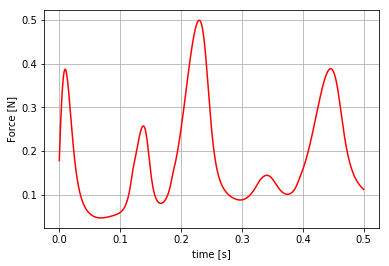

In [12]:
plt.figure()
plt.plot(t,F_tendon_norm, c = 'red')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')

## Tendon Force

Text(0,0.5,'Force [N]')

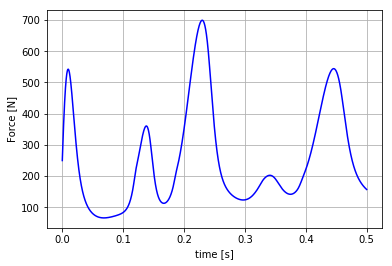

In [13]:
plt.figure()
plt.plot(t,F_tot, c = 'blue')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')

## Length

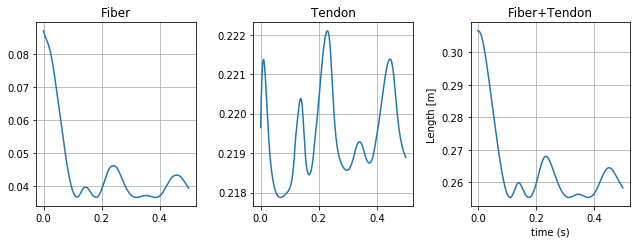

In [14]:
fig,  ax  =  plt.subplots(1, 3, figsize=(9, 3.5), sharex=True)

ax[0].plot(t, fiber_length, label = 'Fiber')
ax[0].set_title('Fiber')
ax[0].grid()
ax[1].plot(t, tendon_length, label = 'Tendon')
ax[1].set_title('Tendon')
ax[1].grid()
ax[2].plot(t, fiber_length+tendon_length, label = 'Fiber+Tendon')
ax[2].set_title('Fiber+Tendon')
ax[2].grid()
plt.xlabel('time (s)')
plt.ylabel('Length [m]')
plt.tight_layout()


## Activation

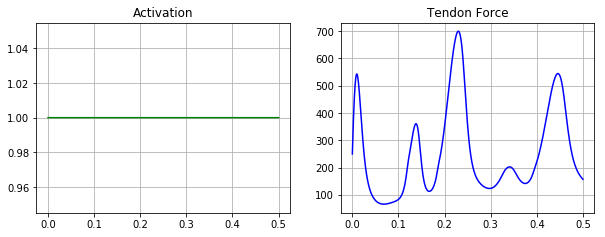

In [15]:
fig,  ax  =  plt.subplots(1, 2, figsize=(10, 3.5), sharex=True)

ax[0].plot(t, a, c = 'green')
ax[0].set_title('Activation')
ax[0].grid()
ax[1].plot(t, F_tot, c = 'blue')
ax[1].set_title('Tendon Force')
ax[1].grid()

## Joint Moment

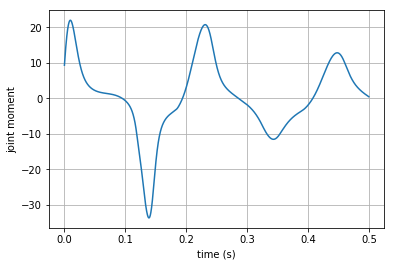

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t, moment)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('joint moment')
plt.show()

## Angle and Velocity

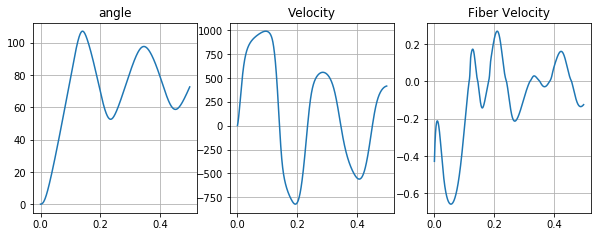

In [17]:
fig,  ax  =  plt.subplots(1, 3, figsize=(10, 3.5), sharex=True)

ax[0].plot(t, angle_phi*180/np.pi)
ax[0].set_title('angle')
ax[0].grid()
ax[1].plot(t, velocity_phi*180/np.pi)
ax[1].set_title('Velocity')
ax[1].grid()
ax[2].plot(t,fibervelocity)
ax[2].set_title('Fiber Velocity')
ax[2].grid()